# 이동통신 고객 이탈 예측

* 여러분은 OO 통신화사 데이터분석가 입니다.
* 00 통신회사의 올해 고객 목표는, **현재 고객수를 유지**하는 것입니다.
* 더욱 치열해진 경쟁 상황에서 고객수를 유지하는 것은 굉장히 도전적인 목표 입니다.
* 이를 위해 회사는 약정기간이 끝난 고객이 번호이동(이탈)해 가는 문제를 해결하고자 합니다.
* 그래서 에이블러 여러분에게, 어떤 고객이 번호이동(이탈)해 가는지 예측 모델링을 의뢰하였습니다.

![](https://d18lkz4dllo6v2.cloudfront.net/cumulus_uploads/entry/23964/mobile%20phones.png)

## 0.환경설정

### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

### 2) 데이터 로딩

In [2]:
# mobile data
data_path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_NA2.csv"
data = pd.read_csv(data_path)
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,544,1,47711,183,17,730589.0,192,19,5,unsat,little,considering,0
1,689,0,74132,191,43,535092.0,349,15,2,unsat,very_little,no,1
2,3134,1,150419,0,14,204004.0,682,0,6,unsat,very_high,considering,0
3,12523,0,159567,0,58,281969.0,634,1,1,very_unsat,very_high,never_thought,0
4,2374,1,23392,0,0,216707.0,233,0,15,unsat,very_little,no,1


|변수 명|내용|구분|
|	----	|	----	|	----	|
|	COLLEGE	|	대학졸업 여부(1,0) - 범주	|		|
|	INCOME	|	연 수입액(달러)	|		|
|	OVERAGE	|	월 초과사용 시간(분)	|		|
|	LEFTOVER	|	월 사용 잔여시간비율(%)	|		|
|	HOUSE	|	집 가격(달러)	|		|
|	HANDSET_PRICE	|	핸드폰 가격(달러)	|		|
|	OVER_15MINS_CALLS_PER_MONTH	|	 평균 장기통화(15분 이상) 횟수	|		|
|	AVERAGE_CALL_DURATION	|	평균 통화시간(분)	|		|
|	REPORTED_SATISFACTION	|	만족도 설문('very_unsat', 'unsat', 'avg', 'sat', 'very_sat' ) - 범주	|		|
|	REPORTED_USAGE_LEVEL	|	사용 수준 설문('very_little', 'little', 'avg', 'high', 'very_high') - 범주	|		|
|	CONSIDERING_CHANGE_OF_PLAN	|	변경 계획 설문('never_thought', 'no', 'perhaps', 'considering',   'actively_looking_into_it') - 범주	|		|
|	**CHURN**	|	이탈여부(1 : 이탈, 0 : 잔류)	|	**Target**	|


----

## 1.데이터 탐색

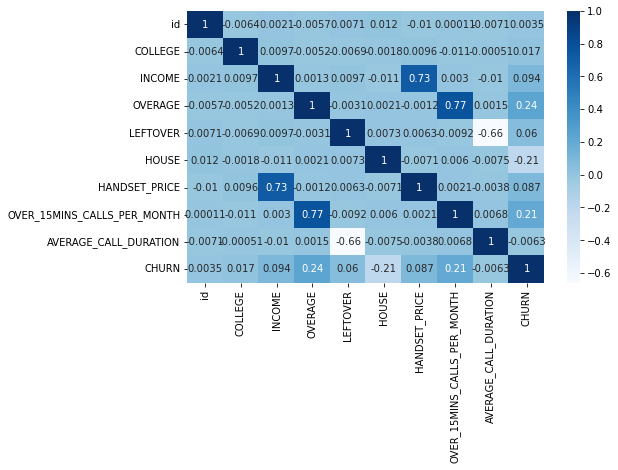

In [3]:
plt.figure(figsize=(8, 5))
sns.heatmap(data.corr(), annot=True, cmap='Blues')
plt.show()

## 2.데이터 전처리 

In [4]:
target = 'CHURN'

### 2.1 데이터 정리

* feature와 , target으로 분할

In [5]:
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [6]:
len(x.columns)

12

In [7]:
# 타겟인 이탈여부와 연관성으로 확인했을때 연관성이 0.08을 기준으로 잡고 관련이 없는 컬럼들 확인
data.corr()[abs(data.corr()[target])<0.08][target]

id                       0.003499
COLLEGE                  0.016748
LEFTOVER                 0.060022
AVERAGE_CALL_DURATION   -0.006333
Name: CHURN, dtype: float64

In [8]:
dum_col = ['id', 'COLLEGE', 'LEFTOVER', 'AVERAGE_CALL_DURATION']
x.drop(dum_col, axis=1, inplace=True)

In [9]:
x.head(2)

,INCOME,OVERAGE,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN
0,47711,183,730589.0,192,19,unsat,little,considering
1,74132,191,535092.0,349,15,unsat,very_little,no


In [10]:
x.shape,y.shape

((18000, 8), (18000,))

### 2.2 NaN에 대한 조치

- KNN IMPUTER로 채울 예정 - > 가변수화 진행 이후 (NULL에 해당하는 데이터중 가장 많은 비중을 차지하는 HOUSE인 집값은 평균값이나 중앙값으로 대체하기에 적절하지 않은 값이라 판단하여 KNN IMPUTER 를 사용하여 채운다. )

In [11]:
x.isna().sum() # House 215, REPORTED_SATISFACTION 38건의 na

INCOME                           0
OVERAGE                          0
HOUSE                          215
HANDSET_PRICE                    0
OVER_15MINS_CALLS_PER_MONTH      0
REPORTED_SATISFACTION           38
REPORTED_USAGE_LEVEL             0
CONSIDERING_CHANGE_OF_PLAN       0
dtype: int64

In [12]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   INCOME                       18000 non-null  int64  
 1   OVERAGE                      18000 non-null  int64  
 2   HOUSE                        17785 non-null  float64
 3   HANDSET_PRICE                18000 non-null  int64  
 4   OVER_15MINS_CALLS_PER_MONTH  18000 non-null  int64  
 5   REPORTED_SATISFACTION        17962 non-null  object 
 6   REPORTED_USAGE_LEVEL         18000 non-null  object 
 7   CONSIDERING_CHANGE_OF_PLAN   18000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 1.1+ MB


### 2.4 가변수화
* 범주형 데이터이면서 값이 0,1 로 되어 있는 것이 아니라면, 가변수화를 수행

In [13]:
x.head(3)

,INCOME,OVERAGE,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN
0,47711,183,730589.0,192,19,unsat,little,considering
1,74132,191,535092.0,349,15,unsat,very_little,no
2,150419,0,204004.0,682,0,unsat,very_high,considering


In [14]:
dum_cols = ['REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL', 'CONSIDERING_CHANGE_OF_PLAN']

x = pd.get_dummies(x, columns = dum_cols ,drop_first = True)
x.head()

,INCOME,OVERAGE,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,REPORTED_SATISFACTION_sat,REPORTED_SATISFACTION_unsat,REPORTED_SATISFACTION_very_sat,REPORTED_SATISFACTION_very_unsat,REPORTED_USAGE_LEVEL_high,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little,CONSIDERING_CHANGE_OF_PLAN_considering,CONSIDERING_CHANGE_OF_PLAN_never_thought,CONSIDERING_CHANGE_OF_PLAN_no,CONSIDERING_CHANGE_OF_PLAN_perhaps
0,47711,183,730589.0,192,19,0,1,0,0,0,1,0,0,1,0,0,0
1,74132,191,535092.0,349,15,0,1,0,0,0,0,0,1,0,0,1,0
2,150419,0,204004.0,682,0,0,1,0,0,0,0,1,0,1,0,0,0
3,159567,0,281969.0,634,1,0,0,0,1,0,0,1,0,0,1,0,0
4,23392,0,216707.0,233,0,0,1,0,0,0,0,0,1,0,0,1,0


In [15]:
# KNN imputer 를 통해 NA값 해결
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(x)

# 데이터프레임으로 다시 만들기
x = pd.DataFrame(imputed, columns=x.columns)
x.isna().sum()

INCOME                                      0
OVERAGE                                     0
HOUSE                                       0
HANDSET_PRICE                               0
OVER_15MINS_CALLS_PER_MONTH                 0
REPORTED_SATISFACTION_sat                   0
REPORTED_SATISFACTION_unsat                 0
REPORTED_SATISFACTION_very_sat              0
REPORTED_SATISFACTION_very_unsat            0
REPORTED_USAGE_LEVEL_high                   0
REPORTED_USAGE_LEVEL_little                 0
REPORTED_USAGE_LEVEL_very_high              0
REPORTED_USAGE_LEVEL_very_little            0
CONSIDERING_CHANGE_OF_PLAN_considering      0
CONSIDERING_CHANGE_OF_PLAN_never_thought    0
CONSIDERING_CHANGE_OF_PLAN_no               0
CONSIDERING_CHANGE_OF_PLAN_perhaps          0
dtype: int64

In [16]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 17 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   INCOME                                    18000 non-null  float64
 1   OVERAGE                                   18000 non-null  float64
 2   HOUSE                                     18000 non-null  float64
 3   HANDSET_PRICE                             18000 non-null  float64
 4   OVER_15MINS_CALLS_PER_MONTH               18000 non-null  float64
 5   REPORTED_SATISFACTION_sat                 18000 non-null  float64
 6   REPORTED_SATISFACTION_unsat               18000 non-null  float64
 7   REPORTED_SATISFACTION_very_sat            18000 non-null  float64
 8   REPORTED_SATISFACTION_very_unsat          18000 non-null  float64
 9   REPORTED_USAGE_LEVEL_high                 18000 non-null  float64
 10  REPORTED_USAGE_LEVEL_little       

In [17]:
x.shape, y.shape

((18000, 17), (18000,))

### 2.5 (옵션)스케일링 

In [36]:
x = (x - x.min()) / (x.max() - x.min())
# x.max(), x.min()
# x.info()

In [21]:
# import tensorflow as tf
# from tensorflow import keras
# import sklearn
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = (x_test - x_train.min()) / (x_train.max() - x_train.min())
# x_train.min(), x_train.max(), x_test.min(), x_test.max()

(0.0, 1.0, -1.4292350019651234e-05, 1.0002787008253833)

### 2.6 데이터 분할

In [19]:
### data ==> train, test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=3000, random_state = 2022)

In [38]:
# train ==> train : val
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=3000, random_state = 2022)

In [40]:
x_train.shape, x_test.shape, x_val.shape

((12000, 17), (3000, 17), (3000, 17))

In [42]:
x.head(3)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 17 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   INCOME                                    18000 non-null  float64
 1   OVERAGE                                   18000 non-null  float64
 2   HOUSE                                     18000 non-null  float64
 3   HANDSET_PRICE                             18000 non-null  float64
 4   OVER_15MINS_CALLS_PER_MONTH               18000 non-null  float64
 5   REPORTED_SATISFACTION_sat                 18000 non-null  float64
 6   REPORTED_SATISFACTION_unsat               18000 non-null  float64
 7   REPORTED_SATISFACTION_very_sat            18000 non-null  float64
 8   REPORTED_SATISFACTION_very_unsat          18000 non-null  float64
 9   REPORTED_USAGE_LEVEL_high                 18000 non-null  float64
 10  REPORTED_USAGE_LEVEL_little       

## 3.모델링1 : 머신러닝

### 3.1 모델링을 위한 함수 불러오기

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import mean_absolute_error

### 3.2 모델링

In [44]:
mod = {}

In [46]:
x_train.shape, x_test.shape, x_val.shape

((12000, 17), (3000, 17), (3000, 17))

#### (1) Linear Regression 모델

In [57]:
model = LinearRegression()

In [58]:
model.fit(x_train,y_train)

LinearRegression()

In [59]:
# print(list(x_train))
print(model.coef_.round(3))
print(model.intercept_.round(3))

[ 0.103  0.373 -0.354  0.067  0.097 -0.018  0.024  0.01   0.019 -0.043
 -0.029 -0.018 -0.023  0.009  0.001  0.02   0.057]
0.446


In [60]:
y_pred_lr = model.predict(x_val)
print(mean_absolute_error(y_val, y_pred_lr))
mod['Linear Regression'] = mean_absolute_error(y_val, y_pred_lr)

0.44184137377344107


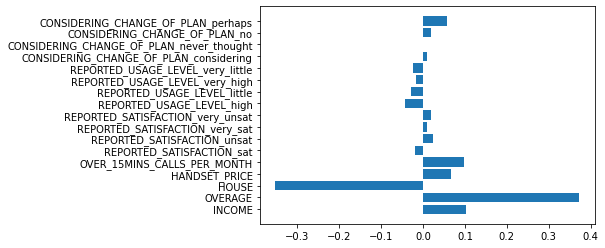

In [61]:
plt.barh(y=list(x), width=model.coef_.reshape(-1))
plt.show()
# 집값과 초과사용시간이 고객이탈에 큰 영향이 있는것으로 파악됨

#### (2) Decision Tree 모델

In [93]:
m_dt = DecisionTreeRegressor(random_state= 2022)
param = {'max_depth': range(1,5)}
model = GridSearchCV(m_dt, param, cv=5, scoring='r2')

In [94]:
model.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=2022),
             param_grid={'max_depth': range(1, 5)}, scoring='r2')

In [95]:
y_pred_dt = model.predict(x_val)
print(mean_absolute_error(y_val, y_pred_dt))
mod['Decision Tree'] = mean_absolute_error(y_val, y_pred_dt)

0.4048562440461869


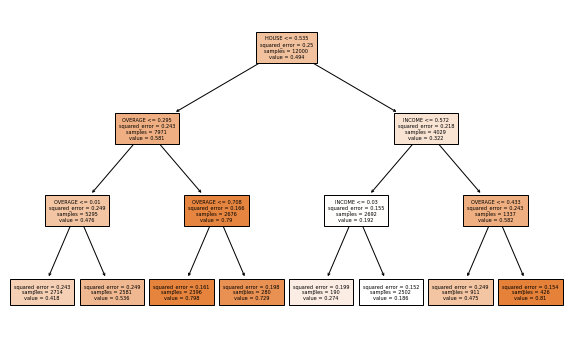

In [96]:
from sklearn.tree import plot_tree

plt.figure(figsize=(10,6))
plot_tree(model.best_estimator_,
          filled=True,
          feature_names=list(x),
          fontsize=5
         )
plt.show()

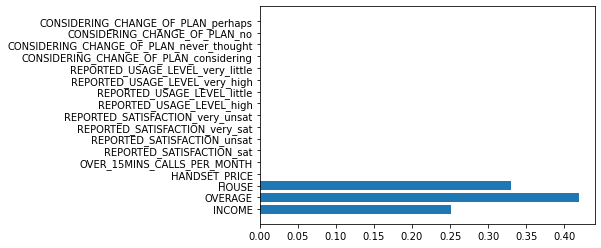

In [83]:
plt.barh(y=list(x), width=model.best_estimator_.feature_importances_)
plt.show()
# 변수 중요도로 확인결과 고객이탈에는 초과통화사용시간, 수입, 집값 의 변수가 중요한 역할을 하는것으로 판단된다.
# 돈과 관련된 각각의 변수들이며, 초과통화사용시간이 가장 큰 변수임으로 보아 이 변수와 연관된 EDA를 진행하여 고객이탈을 방지할수 있을것이라 판단된다.

In [98]:
train_mse, val_mse = [],[]

depth = list(range(1,10))
for d in depth :
    model_dt = DecisionTreeRegressor(max_depth = d)
    model_dt.fit(x_train, y_train)
    train_pred_dt = model_dt.predict(x_train)
    val_pred_dt = model_dt.predict(x_val)
    train_mse.append(mean_absolute_error(y_train, train_pred_dt))
    val_mse.append(mean_absolute_error(y_val, val_pred_dt))

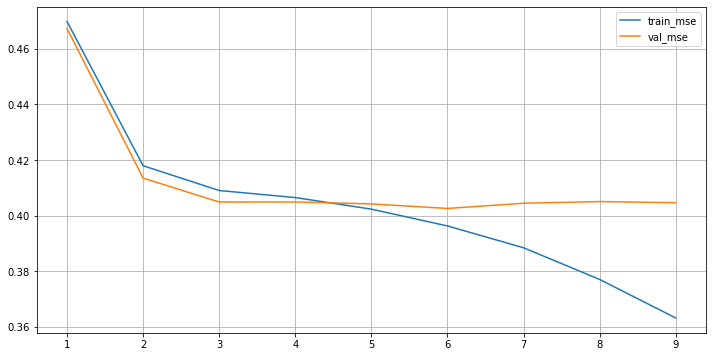

In [99]:
plt.figure(figsize = (12,6))
plt.plot(depth, train_mse, label = 'train_mse')
plt.plot(depth, val_mse, label = 'val_mse')
plt.legend()
plt.grid()
plt.show()
# 4.5 정도가 적당함임을 확인가능

#### (3) KNN 모델

In [86]:
md_knn = KNeighborsRegressor()
param = {'n_neighbors': range(5, 31)}

model = GridSearchCV(md_knn, param, cv= 10, scoring='r2')

In [88]:
model.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(5, 31)}, scoring='r2')

In [91]:
print(model.best_params_)
print(model.best_score_)

{'n_neighbors': 30}
0.08453620953656103


In [92]:
y_pred_knn = model.predict(x_val)
print(mean_absolute_error(y_val, y_pred_knn))
mod['KNN'] = mean_absolute_error(y_val, y_pred_knn)

0.4505111111111111


#### (4) Random Forest

In [100]:
model = RandomForestRegressor(random_state=2022)

In [101]:
model.fit(x_train,y_train)

RandomForestRegressor(random_state=2022)

In [102]:
y_pred_rf = model.predict(x_val)
print(mean_absolute_error(y_val, y_pred_rf))
mod['Random Forest'] = mean_absolute_error(y_val, y_pred_rf)

0.4090066666666667


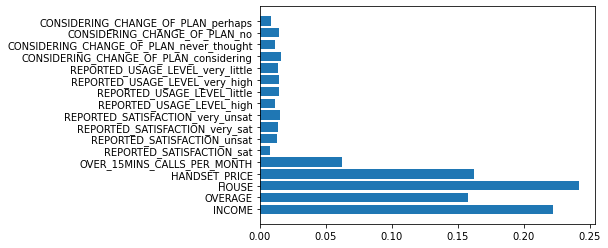

In [103]:
plt.barh(y=list(x), width=model.feature_importances_)
plt.show()
# 이전 분석에 크게 중요한 특징이였던 집값과 초과통화시간 수입도 중요한 변수로 나왔지만, 핸드폰 가격이 중요 요인이라는
# 결과가 도출되었으며, 핸드폰 가격은 이전 변수의 특징인 돈과 관련된 바로 돈이 이탈률과 매우 연관됨을 확인 할 수있다.
# 또한 핸드폰가격이 이탈률에 영향을 미치는것으로 보아 최신기종을 사용하는 사람일수록 이탈률이 크다고 볼 수 있다.

## 4.모델링2 : DL

### 4.1 모델링을 위한 함수 불러오기

In [104]:
import tensorflow as tf
from tensorflow import keras

### 4.2 모델링


In [129]:
x_train.shape, y_train.shape

((12000, 17), (12000,))

#### (1) 모델1

In [132]:
keras.backend.clear_session()

il = keras.layers.Input(shape=(17,))
hl = keras.layers.Dense(512, activation='relu')(il)
hl = keras.layers.Dense(256, activation='relu')(hl)
hl = keras.layers.Dense(128, activation='relu')(hl)
ol = keras.layers.Dense(1)(hl)

model1 = keras.models.Model(il, ol)

model1.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(learning_rate=0.01))

model1.summary()

# Functional API를 사용해 모델링을 하였으며, 히든레이어를 512, 256, 128 순으로 줄여나간 이유는 해당 문제는 이동통신
# 고객의 이탈을 방지하기 위한 즉, 유지를 위한 해결안을 찾는 방향으로, 고객들이 이탈하는 원인중 핵심요소를 추출해
# 내는 과정이므로, Hidden layer 를 거쳐 점차 특징을 줄여나가는 방향으로 해서 핵심 특징들만 추출하기 위함이다.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense (Dense)               (None, 512)               9216      
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 173,569
Trainable params: 173,569
Non-trainable params: 0
_________________________________________________________________


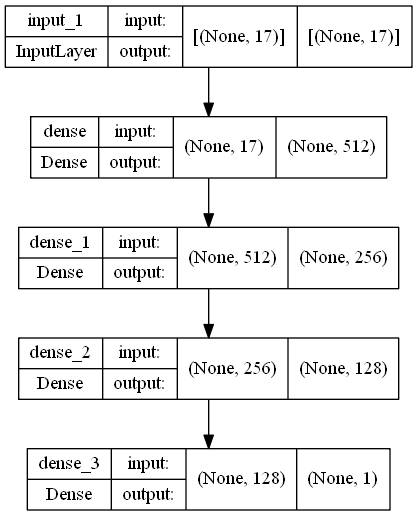

In [107]:
keras.utils.plot_model(model1, show_shapes=True)

#### (2) 모델2

In [136]:
keras.backend.clear_session()

model2 = keras.models.Sequential()
model2.add(keras.layers.Input(shape=(17,)))
model2.add(keras.layers.Dense(1))
model2.compile(loss = keras.losses.mean_absolute_error , optimizer = keras.optimizers.Adam(learning_rate=0.01)) 
model2.summary()

# Sequential API를 사용한 모델2는 Dense나 Concat 등 다양한 방법을 사용해서 모델링도 할 수 있지만 가장 기초적인
# 모델링을 수행해 보았다. 그리하여 이전 Dense를 사용하여 특징을 추출한 모델1과의 차이를 구분하기에 뚜렷한 지표가
# 될 모델이라 생각해 해당 모델2를 구성하였다.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 18        
                                                                 
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


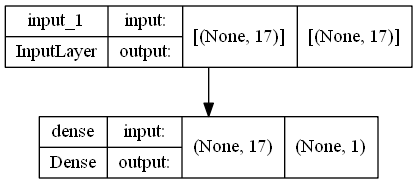

In [110]:
keras.utils.plot_model(model2, show_shapes=True)

In [112]:
x_train.columns

Index(['INCOME', 'OVERAGE', 'HOUSE', 'HANDSET_PRICE',
       'OVER_15MINS_CALLS_PER_MONTH', 'REPORTED_SATISFACTION_sat',
       'REPORTED_SATISFACTION_unsat', 'REPORTED_SATISFACTION_very_sat',
       'REPORTED_SATISFACTION_very_unsat', 'REPORTED_USAGE_LEVEL_high',
       'REPORTED_USAGE_LEVEL_little', 'REPORTED_USAGE_LEVEL_very_high',
       'REPORTED_USAGE_LEVEL_very_little',
       'CONSIDERING_CHANGE_OF_PLAN_considering',
       'CONSIDERING_CHANGE_OF_PLAN_never_thought',
       'CONSIDERING_CHANGE_OF_PLAN_no', 'CONSIDERING_CHANGE_OF_PLAN_perhaps'],
      dtype='object')

#### (3) 모델3

In [146]:
x_train3 = x_train.loc[:,['INCOME', 'OVERAGE', 'HOUSE', 'HANDSET_PRICE']]
x_test3 = x_test.loc[:,['INCOME', 'OVERAGE', 'HOUSE', 'HANDSET_PRICE']]

x_etr3 = x_train.loc[:,['OVER_15MINS_CALLS_PER_MONTH', 'REPORTED_SATISFACTION_sat',
       'REPORTED_SATISFACTION_unsat', 'REPORTED_SATISFACTION_very_sat',
       'REPORTED_SATISFACTION_very_unsat', 'REPORTED_USAGE_LEVEL_high',
       'REPORTED_USAGE_LEVEL_little', 'REPORTED_USAGE_LEVEL_very_high',
       'REPORTED_USAGE_LEVEL_very_little',
       'CONSIDERING_CHANGE_OF_PLAN_considering',
       'CONSIDERING_CHANGE_OF_PLAN_never_thought',
       'CONSIDERING_CHANGE_OF_PLAN_no', 'CONSIDERING_CHANGE_OF_PLAN_perhaps']]

x_ete3 = x_test.loc[:,['OVER_15MINS_CALLS_PER_MONTH', 'REPORTED_SATISFACTION_sat',
       'REPORTED_SATISFACTION_unsat', 'REPORTED_SATISFACTION_very_sat',
       'REPORTED_SATISFACTION_very_unsat', 'REPORTED_USAGE_LEVEL_high',
       'REPORTED_USAGE_LEVEL_little', 'REPORTED_USAGE_LEVEL_very_high',
       'REPORTED_USAGE_LEVEL_very_little',
       'CONSIDERING_CHANGE_OF_PLAN_considering',
       'CONSIDERING_CHANGE_OF_PLAN_never_thought',
       'CONSIDERING_CHANGE_OF_PLAN_no', 'CONSIDERING_CHANGE_OF_PLAN_perhaps']]

In [147]:
x_train.shape, x_train3.shape, x_etr3.shape

((12000, 17), (12000, 4), (12000, 13))

In [148]:
keras.backend.clear_session()

il1 = keras.layers.Input(shape=(4,))
hl1 = keras.layers.Dense(256, activation='relu')(il1)

il2 = keras.layers.Input(shape=(13,))
hl2 = keras.layers.Dense(256, activation='relu')(il2)

cl = keras.layers.Concatenate()([hl1, hl2])
ol = keras.layers.Dense(1)(cl)

model3 = keras.models.Model([il1, il2], ol)

model3.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(learning_rate=0.01))

model3.summary()

# 위의 모델링에서 각각 중요한 변수였던 핸드폰가격, 집값, 초과통화시간, 수입을 모아 따로 구성하여 모델링 하여 더 좋은
# 모델이 될 수 있을것이라 판단해 진행하였다.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          1280        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 256)          3584        ['input_2[0][0]']                
                                                                                              

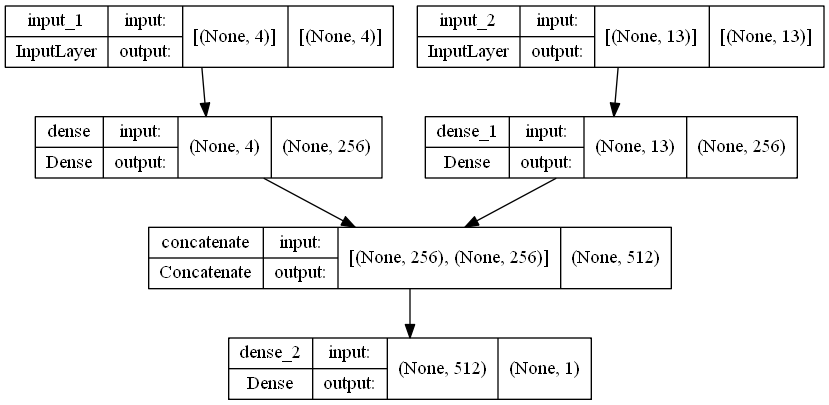

In [143]:
keras.utils.plot_model(model3, show_shapes=True)

## 학습

In [125]:
from tensorflow.keras.callbacks import EarlyStopping

In [126]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   min_delta=0,
                                   patience=5,
                                   verbose=1,
                                   restore_best_weights=True)

In [130]:
x_train.shape, y_train.shape

((12000, 17), (12000,))

In [133]:
model1.fit(x_train, y_train, epochs=600, validation_split=0.15, verbose=1, callbacks=[es])

Epoch 1/600
319/319 [==============================] - 2s 4ms/step - loss: 0.4240 - val_loss: 0.4010
Epoch 2/600
319/319 [==============================] - 1s 4ms/step - loss: 0.3853 - val_loss: 0.3960
Epoch 3/600
319/319 [==============================] - 1s 4ms/step - loss: 0.3765 - val_loss: 0.3780
Epoch 4/600
319/319 [==============================] - 1s 4ms/step - loss: 0.3657 - val_loss: 0.3784
Epoch 5/600
319/319 [==============================] - 1s 4ms/step - loss: 0.3665 - val_loss: 0.3817
Epoch 6/600
319/319 [==============================] - 1s 4ms/step - loss: 0.3632 - val_loss: 0.3680
Epoch 7/600
319/319 [==============================] - 1s 4ms/step - loss: 0.3645 - val_loss: 0.3837
Epoch 8/600
319/319 [==============================] - 1s 4ms/step - loss: 0.3615 - val_loss: 0.3608
Epoch 9/600
319/319 [==============================] - 1s 4ms/step - loss: 0.3523 - val_loss: 0.3545
Epoch 10/600
319/319 [==============================] - 1s 4ms/step - loss: 0.3554 - val_lo

In [162]:
y_pred_m1 = model1.predict(x_val)
print(mean_absolute_error(y_test, y_pred_m1))
mod['DLM1'] = mean_absolute_error(y_test, y_pred_m1)

# 특징을 512 ~ 128까지 Dense를 거쳐 줄여나가는 과정이 기존의 randomforest, knn 등의 알고리즘을 사용한 모델링의 결과
# 보다 떨어지는 성능이 도출되었다. 즉, 해당문제에서 특징을 줄여나가는 방법은 좋은 방법이 아니다.

0.4866597585187604


In [137]:
model2.fit(x_train, y_train, epochs=600, validation_split=0.15, verbose=1, callbacks=[es])

Epoch 1/600
319/319 [==============================] - 1s 3ms/step - loss: 0.4628 - val_loss: 0.4193
Epoch 2/600
319/319 [==============================] - 1s 2ms/step - loss: 0.4162 - val_loss: 0.4219
Epoch 3/600
319/319 [==============================] - 1s 2ms/step - loss: 0.4150 - val_loss: 0.4179
Epoch 4/600
319/319 [==============================] - 1s 2ms/step - loss: 0.4138 - val_loss: 0.4135
Epoch 5/600
319/319 [==============================] - 1s 2ms/step - loss: 0.4136 - val_loss: 0.4145
Epoch 6/600
319/319 [==============================] - 1s 2ms/step - loss: 0.4140 - val_loss: 0.4173
Epoch 7/600
319/319 [==============================] - 1s 2ms/step - loss: 0.4135 - val_loss: 0.4115
Epoch 8/600
319/319 [==============================] - 1s 2ms/step - loss: 0.4141 - val_loss: 0.4128
Epoch 9/600
319/319 [==============================] - 1s 2ms/step - loss: 0.4130 - val_loss: 0.4131
Epoch 10/600
319/319 [==============================] - 1s 2ms/step - loss: 0.4131 - val_lo

In [163]:
y_pred_m2 = model2.predict(x_val)
print(mean_absolute_error(y_test, y_pred_m2))
mod['DLM2'] = mean_absolute_error(y_test, y_pred_m2)

# 기존의 모델링을 설계할때 예측한 바와 다르게 model1과 차이가 뚜렷하게 구분되지 않았다. 가장 기초적인 방법을 통한
# 모델링이다 보니 knn이나 logistic regression 등 과 어느정도 유사하지만 보다 못한 결과가 도출되었다.

0.502429569674035


In [ ]:
x_train3.shape, x_etr3.shape

In [149]:
model3.fit([x_train3, x_etr3], y_train , epochs=600, validation_split=0.15, verbose=1, callbacks=[es])

Epoch 1/600
319/319 [==============================] - 1s 3ms/step - loss: 0.4103 - val_loss: 0.4114
Epoch 2/600
319/319 [==============================] - 1s 2ms/step - loss: 0.3936 - val_loss: 0.3820
Epoch 3/600
319/319 [==============================] - 1s 2ms/step - loss: 0.3826 - val_loss: 0.3811
Epoch 4/600
319/319 [==============================] - 1s 2ms/step - loss: 0.3794 - val_loss: 0.3877
Epoch 5/600
319/319 [==============================] - 1s 2ms/step - loss: 0.3717 - val_loss: 0.3773
Epoch 6/600
319/319 [==============================] - 1s 2ms/step - loss: 0.3733 - val_loss: 0.3718
Epoch 7/600
319/319 [==============================] - 1s 2ms/step - loss: 0.3689 - val_loss: 0.3773
Epoch 8/600
319/319 [==============================] - 1s 2ms/step - loss: 0.3686 - val_loss: 0.3787
Epoch 9/600
319/319 [==============================] - 1s 2ms/step - loss: 0.3668 - val_loss: 0.3771
Epoch 10/600
319/319 [==============================] - 1s 2ms/step - loss: 0.3657 - val_lo

In [164]:
y_pred_m3 = model3.predict([x_test3, x_ete3])
print(mean_absolute_error(y_test, y_pred_m3))
mod['DLM3'] = mean_absolute_error(y_test, y_pred_m3)

# 중요 feature들로 나눠서 진행한 모델링이 기존의 다른 모델링의 결과에 비해 월등히 뛰어난 결과가 도출되었다.

0.3502485544246932


## 5.성능 비교

In [177]:
mod 
# 평가지표로 mean_absolute_error 를 선정한 이유는 평균으로부터 어느정도 떨어진지 절대값을 통해 확인이 가능해 어떠한
# 요인이 고객이탈에 어느정도 떨어져 있는지 정확하게 판단할 수 있는 근거로써 사용할 수 있기에 평가지표 를 mae를 사용
# 하였다.

{'Linear Regression': 0.44184137377344107,
 'Decision Tree': 0.4048562440461869,
 'KNN': 0.4505111111111111,
 'Random Forest': 0.4090066666666667,
 'DLM1': 0.4866597585187604,
 'DLM2': 0.502429569674035,
 'DLM3': 0.3502485544246932}

In [168]:
mod.keys(), mod.values()

(dict_keys(['Linear Regression', 'Decision Tree', 'KNN', 'Random Forest', 'DLM1', 'DLM2', 'DLM3']),
 dict_values([0.44184137377344107, 0.4048562440461869, 0.4505111111111111, 0.4090066666666667, 0.4866597585187604, 0.502429569674035, 0.3502485544246932]))

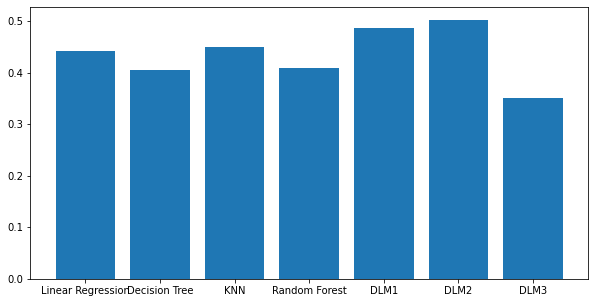

In [176]:
plt.figure(figsize=(10,5))
plt.bar(mod.keys(),mod.values())
plt.show()

# 해당 그래프로 확인이 가능하듯 핵심 요소를 따로 구분하여 진행한 딥러닝 모델이 가장 성능이 좋게 나왔다.
# 즉 핵심 feature로 선정한 수입, 핸드폰가격, 집값, 초과통화시간이 고객이탈에 큰 영향을 주는것으로 증명이 되었다.